In [57]:
import os, sys

def find_project_root(start_path):
    cur = os.path.abspath(start_path)
    while True:
        if os.path.isdir(os.path.join(cur, "src")):
            return cur
        parent = os.path.dirname(cur)
        if parent == cur:
            break
        cur = parent
    raise RuntimeError("Project root not found.")

ROOT = find_project_root(os.getcwd())
sys.path.append(ROOT)
os.chdir(ROOT)

print("ROOT:", ROOT)
print("CWD :", os.getcwd())


ROOT: c:\Users\sam\Documents\VSCode_tunnel\cv_2024_upscale
CWD : c:\Users\sam\Documents\VSCode_tunnel\cv_2024_upscale


Found 492 image pairs.


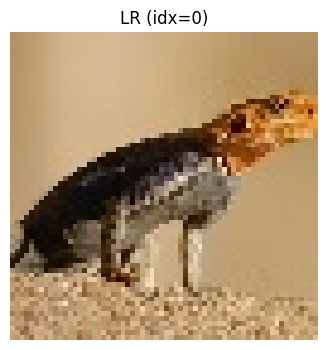

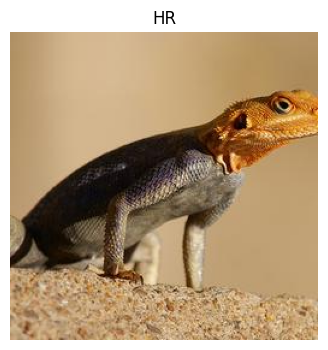

In [58]:
from src.data.dataset_pairs import UpscaleDataset

dataset = UpscaleDataset(
    lr_dir="data/train_lr",
    hr_dir="data/train_hr",
)
idx = 0
lr, hr = dataset[idx]
show_tensor(lr, f"LR (idx={idx})")
show_tensor(hr, "HR")

In [59]:
import torch
from src.models.srcnn import SRCNN
from src.models.unet_sr import UNetSR

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using:", device)

srcnn = SRCNN().to(device)
unet  = UNetSR().to(device)

srcnn.load_state_dict(torch.load("models_ckpt/srcnn_final.pth", map_location=device))
unet.load_state_dict(torch.load("models_ckpt/unet_final.pth", map_location=device))

srcnn.eval()
unet.eval()

Using: cuda


UNetSR(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): DoubleConv(
      (double_conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(128, eps=1e-05

In [60]:
def show_tensor(img, title=""):
    img_np = img.permute(1, 2, 0).numpy()  # CHW → HWC
    plt.figure(figsize=(4,4))
    plt.imshow(img_np)
    plt.title(title)
    plt.axis("off")
    plt.show()

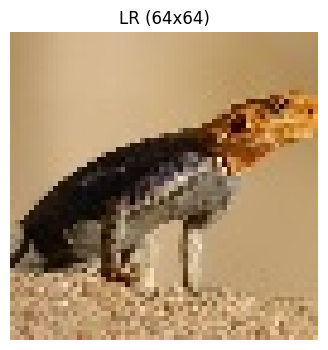

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.11243127..1.0545385].


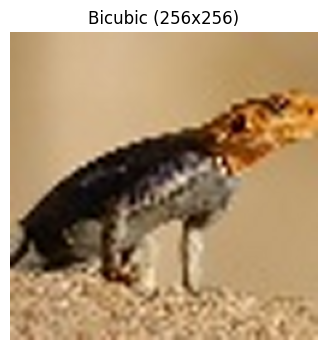

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.039193973..0.93899447].


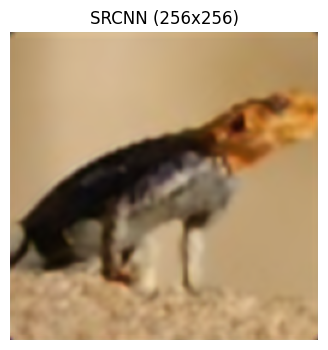

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0089738965..0.8915961].


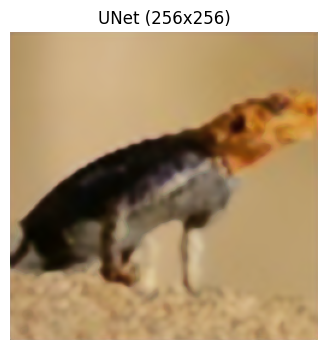

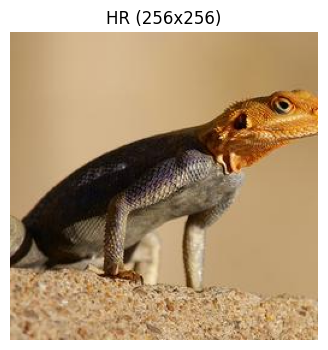

In [61]:
import torch.nn.functional as F

def upscale_bicubic(lr_tensor, scale_factor=4):
    x = lr_tensor.unsqueeze(0)
    x_up = F.interpolate(x, scale_factor=scale_factor, mode="bicubic", align_corners=False)
    return x_up.squeeze(0)

bicubic = upscale_bicubic(lr)

with torch.no_grad():
    lr_in = lr.unsqueeze(0).to(device)
    srcnn_out = srcnn(lr_in).squeeze(0).cpu()
    unet_out  = unet(lr_in).squeeze(0).cpu()

show_tensor(lr,        "LR (64x64)")
show_tensor(bicubic,   "Bicubic (256x256)")
show_tensor(srcnn_out, "SRCNN (256x256)")
show_tensor(unet_out,  "UNet (256x256)")
show_tensor(hr,        "HR (256x256)")

In [62]:
import math
import numpy as np

def psnr_torch(img1, img2):
    mse = torch.mean((img1 - img2) ** 2).item()
    if mse == 0:
        return float("inf")
    return 10 * math.log10(1.0 / mse)

from skimage.metrics import structural_similarity as ssim

def ssim_torch(img1, img2):
    x1 = img1.permute(1,2,0).cpu().numpy()
    x2 = img2.permute(1,2,0).cpu().numpy()
    return ssim(x1, x2, data_range=1.0, channel_axis=2)

print("[Single image]")
print("PSNR values:")
print("  Bicubic: ", psnr_torch(bicubic, hr))
print("  SRCNN  : ", psnr_torch(srcnn_out, hr))
print("  UNet   : ", psnr_torch(unet_out, hr))

print("SSIM values:")
print("  Bicubic: ", ssim_torch(bicubic, hr))
print("  SRCNN  : ", ssim_torch(srcnn_out, hr))
print("  UNet   : ", ssim_torch(unet_out, hr))

[Single image]
PSNR values:
  Bicubic:  21.76124770139002
  SRCNN  :  22.774712543005265
  UNet   :  22.302742986031202
SSIM values:
  Bicubic:  0.6708047
  SRCNN  :  0.67358416
  UNet   :  0.65987474


In [ ]:
N = min(20, len(dataset))
bicubic_psnrs, srcnn_psnrs, unet_psnrs = [], [], []
bicubic_ssims, srcnn_ssims, unet_ssims = [], [], []

for i in range(N):
    lr_i, hr_i = dataset[i]
    bicubic_i = upscale_bicubic(lr_i)
    with torch.no_grad():
        lr_in = lr_i.unsqueeze(0).to(device)
        srcnn_i = srcnn(lr_in).squeeze(0).cpu()
        unet_i  = unet(lr_in).squeeze(0).cpu()

    bicubic_psnrs.append(psnr_torch(bicubic_i, hr_i))
    srcnn_psnrs.append(psnr_torch(srcnn_i, hr_i))
    unet_psnrs.append(psnr_torch(unet_i, hr_i))

    bicubic_ssims.append(ssim_torch(bicubic_i, hr_i))
    srcnn_ssims.append(ssim_torch(srcnn_i, hr_i))
    unet_ssims.append(ssim_torch(unet_i, hr_i))

import numpy as np
print("[Average over", N, "images]")
print("PSNR values:")
print("  Bicubic:", np.mean(bicubic_psnrs))
print("  SRCNN  :", np.mean(srcnn_psnrs))
print("  UNet   :", np.mean(unet_psnrs))

print("SSIM values:")
print("  Bicubic:", np.mean(bicubic_ssims))
print("  SRCNN  :", np.mean(srcnn_ssims))
print("  UNet   :", np.mean(unet_ssims))

[Average over 20 images]
PSNR values:
  Bicubic: 18.601837168236717
  SRCNN  : 19.629299961572194
  UNet   : 19.489317170660513
  Bicubic: 0.425289
  SRCNN  : 0.41065544
  UNet   : 0.40429527
